# Машинное обучение. ВМК МГУ.
## Практическое задание 7: Кластеризация. Методы снижения размерности.

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на unit-тестирование**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза `Ваш ответ здесь: (ｏ・_・)ノ”(ノ_<、)`, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано `# Ваш код здесь:＼(º □ º l|l)/`, то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой `Ваш ответ здесь: (ｏ・_・)ノ”(ノ_<、)`, и ячейка с фразой `# Ваш код здесь:＼(º □ º l|l)/`, то в ответе ожидается и код, и текст)

**В этом задании вы..:**

* Познакомитесь с одним способом визуализации процесса обучения
* Сравните между собой результаты разных способов кластеризации
* Посмотрите и реализуете несколько метрик качества кластеризации
* Попробуете разные методы снижения размерности

### *Примерное время выполнения всех ячеек ноутбука: 30 минут*

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# 0. Введение. [кросспроверка 2 балла]

Здесь перечислены основные функции и библиотеки, которые могут понадобиться Вам в процессе выполнения задания. Подключение других библиотек возможно, но нежелательно. **Работа каких-либо других библиотек не гарантируется.**

In [29]:
import os

import scipy

import numpy as np

import tqdm.auto as tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from ipywidgets import interactive, fixed, interact_manual, IntSlider, FloatLogSlider, FloatSlider

import torch

import sklearn

from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.manifold import TSNE, Isomap

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
import matplotlib
import matplotlib.pyplot as plt

## 0.3 Введение в интерактивные графики jupyter notebook [кросспроверка 2 балла]

Информация об особенностях интерактивных графиков вынесена в отдельный ноутбук [Deep_dive_into_ipynb[Tutorial].ipynb](https://colab.research.google.com/drive/1KKe2z1AqWtgtTjbsoJjqiaUesRF_gsU2?usp=sharing). **Ознакомьтесь с ним перед дальнейшим выполнением задания!**

#### **Задание 0.0 [кросспроверка, 2 балла][код, вопрос]** 
* Сделайте $2\text{-}3$ различных интерактивных графика.
* Посмотрите в чём заключается смысл функций [`interactive`, `interact_manual`, `fixed`, `IntSlider`, `FloatLogSlider`](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html). 
* Какие ещё [слайдеры и динамические виджеты бывают](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html)? 
* Как вам кажется, удобный ли это инструмент? 
* Предложите несколько примеров, когда он мог бы ещё пригодиться.

In [4]:
plt.style.use("ggplot")
matplotlib.rcParams['figure.dpi'] = 100

In [5]:
from scipy import stats
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

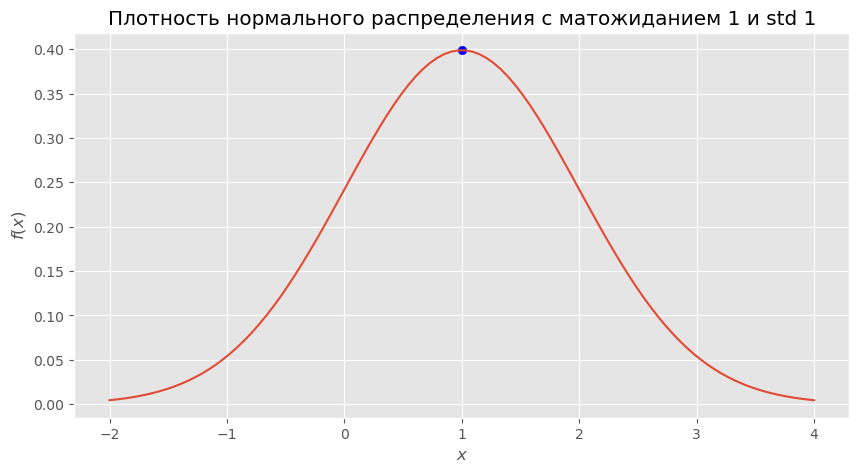

In [11]:
def normal_print(loc, scale):
  norm_rv = stats.norm(loc=loc, scale=scale) 
  plt.figure(figsize=(10,5))
  plt.title("Плотность нормального распределения с матожиданием {} и std {}".format(loc, scale))
  x = np.linspace(loc-3,loc+ 3, 100)
  pdf = norm_rv.pdf(x)
  plt.plot(x, pdf)
  plt.ylabel("$f(x)$")
  plt.xlabel("$x$")
  plt.scatter([1], [norm_rv.pdf(1)], color="blue")
  plt.show()

    
#interact(normal_print, loc=2, scale=1); поигрался с этим всё окей, но в чате написали статистические только оставить
normal_print(1,1)

Может быть удобно для выбора каких-то категориальных переменных.

<font color='red'>**Обратите внимание, что динамическое содержимое может некорректно сохраняться в jupyter notebook. Используйте его только для локальной визуализации. Все графики, необходимые для сдачи задания должны быть статическими. Переход в статический режим происходит с помощью магической команды `%matplotlib inline` (приведена ниже).**</font>

**Обязательно убедитесь, что все графики корректно сохранились корректно в ноутбуке перед сдачей в систему.**

In [7]:
%matplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams['figure.dpi'] = 100

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Кластеризация на синтетических данных. [кросспроверка 9 баллов,  unittests 16 баллов]

## a. Двумерные данные

Сгенерируем двумерные данные с $4$ естественными кластерами разного размера и плотности.

In [13]:
data_moons, labels_moons = make_moons(n_samples=300, shuffle=True, noise=0.09, random_state=6417)
data_moons, labels_moons = data_moons[labels_moons == 0], labels_moons[labels_moons == 0]

data_blobs, labels_blobs = make_blobs(
    n_samples=500, n_features=2, centers=[(0, -0.2), (-1.5, -1.5), (-1.5, 1.5)], 
    cluster_std=[0.2, 0.4, 0.6], center_box=[-10.0, 10.0], 
    shuffle=True, random_state=6417, return_centers=False
)

data_moons = data = np.concatenate([data_moons, data_blobs])
labels_moons = labels = np.concatenate([labels_moons, labels_blobs + 1])

In [14]:
def plot_2d_data(data, labels, title='Исходные данные', cmap='tab20', ax=None, scale=None):
    '''
    Отрисовка 2d scatter plot. 
    :param np.ndarray data: 2d массив точек
    :param Union[list, np.ndarray] labels: список меток для каждой точки выборки
    :param str title: Заголовок графика
    :param str cmap: Цветовая палитра
    :param ax Optional[matplotlib.axes.Axes]: Оси для отрисовки графика.
        Если оси не заданы, то создаётся новая фигура и сразу же происходит её отрисовка
        Иначе, график добавляется на существуюущие оси. Отрисовки фигуры не происходит
    '''
    n_clusters = len(np.unique(labels))
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig = None
        
    scatter = ax.scatter(
        data[:, 0], data[:, 1], c=labels, 
        cmap=plt.get_cmap(cmap, n_clusters), s = scale
    )

    cbar = plt.colorbar(scatter, label='Номер кластера', ax=ax)
    cbar.set_ticks(np.min(labels) + (np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters)
    cbar.set_ticklabels(np.unique(labels))

    ax.set_title(title)
    ax.grid(True)
    
    if fig is not None:
        fig.tight_layout()
        plt.show()

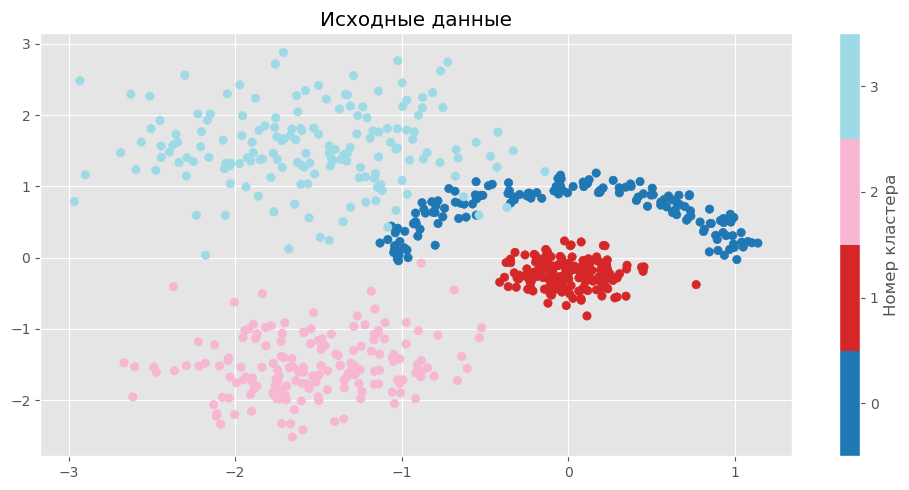

In [15]:
plot_2d_data(data, labels, title='Исходные данные', cmap='tab20')

#### **Задание 1.a.1 [кросспроверка, 1 балл][код]** 
<a id='task_1.a.1'></a>
Запустите следующие алгоритмы кластеризации на данной выборке: `KMeans`, `DBSCAN`, `AgglomerativeClustering`. Визуально подберите наилучшие параметры для этих алгоритмов (`n_clusters`, `eps`, `min_samples`, `linkage`). Изобразите наилучшие получившиеся разбиения на графиках.

*Советы:*
1. Используйте виджеты для ручного подбора параметров
2. Используйте готовую функцию `plot_2d_data` для отрисовки графиков. Обязательно меняйте заголовок

In [16]:
def set_base_settings():
  %matplotlib inline
  plt.style.use("ggplot")
  matplotlib.rcParams['figure.dpi'] = 100

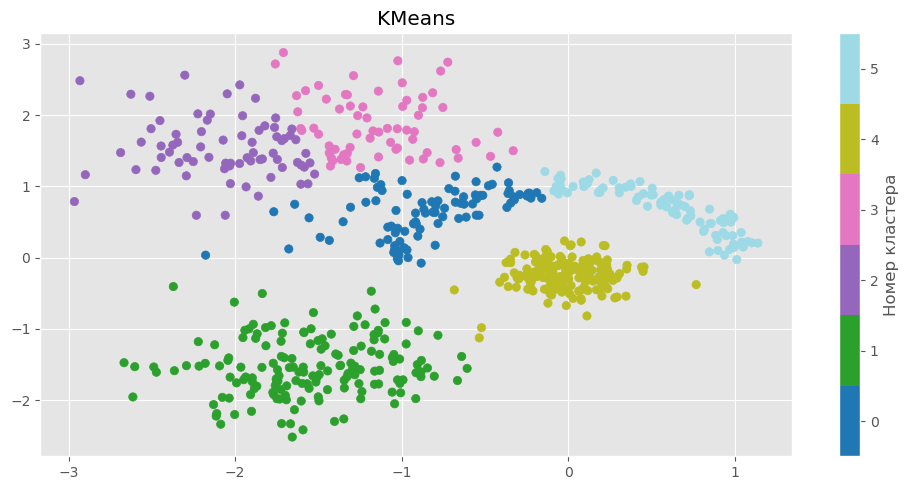

In [19]:
def Km(n_clusters):
  labels = KMeans(n_clusters=int(n_clusters)).fit_predict(data)
  plot_2d_data(data, labels, title='KMeans', cmap='tab20')


interactive_plot = interactive(
    Km,
    n_clusters=FloatSlider(value=3, min=1, max=10, step=1, description=r'n_clusters')
)
#interactive_plot поигрался с этим всё окей, но в чате написали статистические только оставить
Km(6)

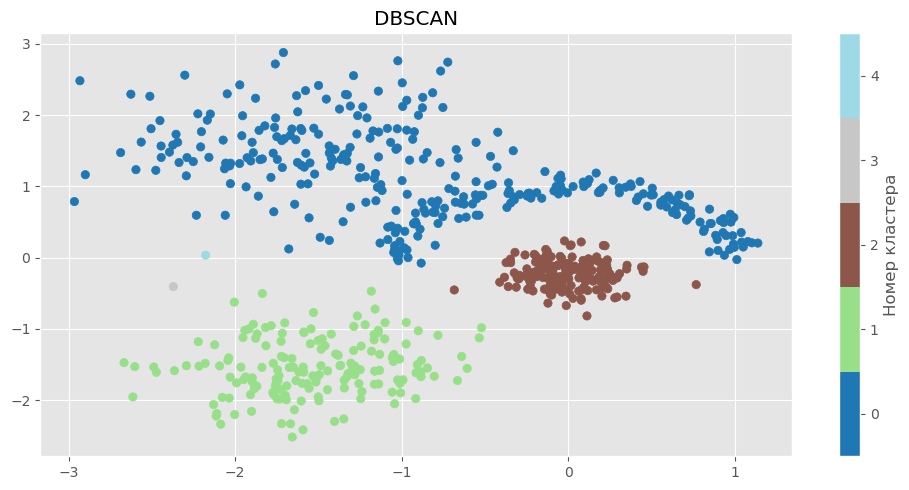

In [21]:
def DBSCAN_pr(eps, min_samples):
    labels_DBSCAN = DBSCAN(eps=eps,
                           min_samples=int(min_samples)).fit_predict(data)
    plot_2d_data(data, labels_DBSCAN, title='DBSCAN', cmap='tab20')

interactive_plot = interactive(
    DBSCAN_pr,
    eps=FloatSlider(value=0.4,
                    min=0.01, max=1.5, step=0.1, description=r'eps'),
    min_samples=FloatSlider(value=3,
                            min=1, max=10, step=1, description=r'min_samples')
)
#interactive_plot поигрался с этим всё окей, но в чате написали статистические только оставить
DBSCAN_pr(0.4, 1)

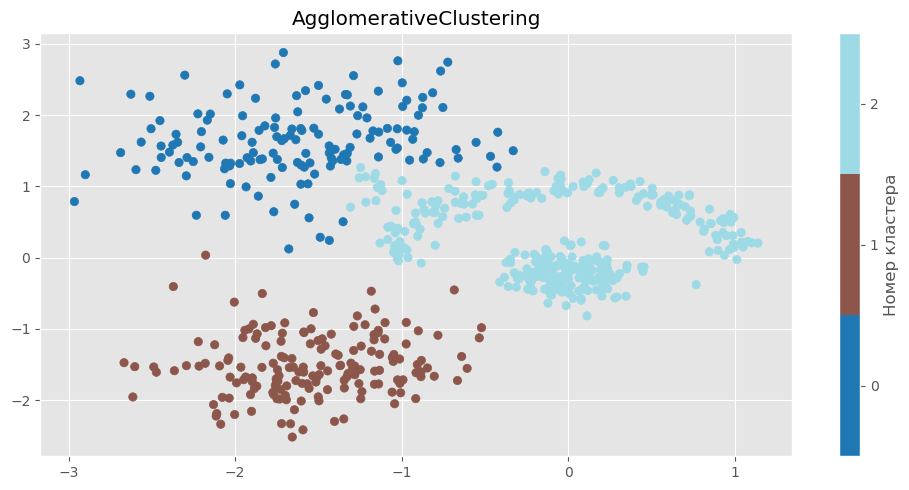

In [23]:
def AggClust(n_clusters):
  labels_AggClust = AgglomerativeClustering(n_clusters=int(n_clusters),
                                            linkage= "average").fit_predict(data)
  plot_2d_data(data, 
               labels_AggClust,
               title='AgglomerativeClustering',
               cmap='tab20')


interactive_plot = interactive(
    AggClust,
    n_clusters=FloatSlider(value=3,
                           min=1,
                           max=10,
                           step=1,
                           description=r'n_clusters')
)
#interactive_plot поигрался с этим всё окей, но в чате написали статистические только оставить
AggClust(3)

#### **Задание 1.a.2 [кросспроверка, 1 балл][вопрос]**
Основываясь на знании о работе данных алгоритмов, объясните, почему кластеры были сформированы таким образом. Какой алгоритм лучше всего работает на предложенных данных?

Лучше всего работает метод KMeans, так как в данных есть выбросы в левой части картинки, которые другие методы относят к отдельным кластерам.

## b. Многомерные данные. Снижение размерности

Теперь попробуем кластеризовать данные в высокоразмерном пространстве. Существенным отличием от двумерного случая является невозможность прямой визуальной оценки кластеризации.

Одним из наглядных способов оценки кластеризации является снижение размерности. В данной части вам предлагается использовать алгоритм `TSNE` для визуализации данных. Подробнее про данный алгоритм можно прочитать в [блоге](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a) и в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

In [32]:
data, labels = make_classification(
    n_samples=1000, n_features=200, n_informative=100,
    n_repeated=0, n_classes=5, n_clusters_per_class=2, weights=None, 
    flip_y=0.01, class_sep=2.5, hypercube=True, shift=0.0, scale=1.0, 
    shuffle=True, random_state=6417
)

#### **Задание 1.b.1 [кросспроверка, 1 балл][код, вопрос]**
Примените алгоритм `TSNE` для снижения размерности до двух. Учтите, что `TSNE` суть есть метрический алгоритм и существенно зависит от масштаба признаков — некорректный и различающийся масштаб признаков гарантированно приведёт к неинтерпретируемым результатам. Можете попробовать подобрать гиперпараметры алгоритма для получения лучшей визуализации.

Изобразите получившиеся низкоразмерные вектора. Получилось ли сохранить кластеры при переходе в низкоразмерное пространство?

In [33]:
sd = StandardScaler().fit_transform(data)

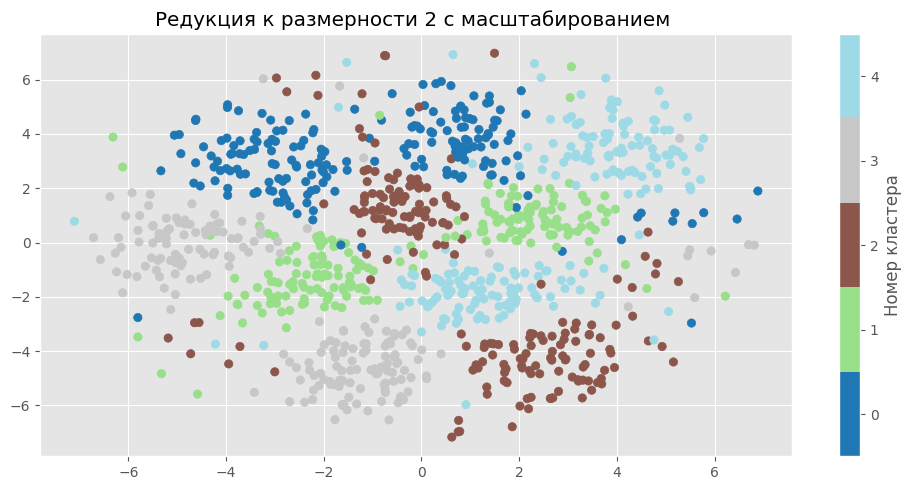

In [217]:
X_embedded_scaled = TSNE(n_components=2,
                         perplexity=65, 
                         early_exaggeration=10).fit_transform(sd) 


plot_2d_data(X_embedded_scaled,
             labels,
             title="Редукция к размерности 2 c масштабированием ");

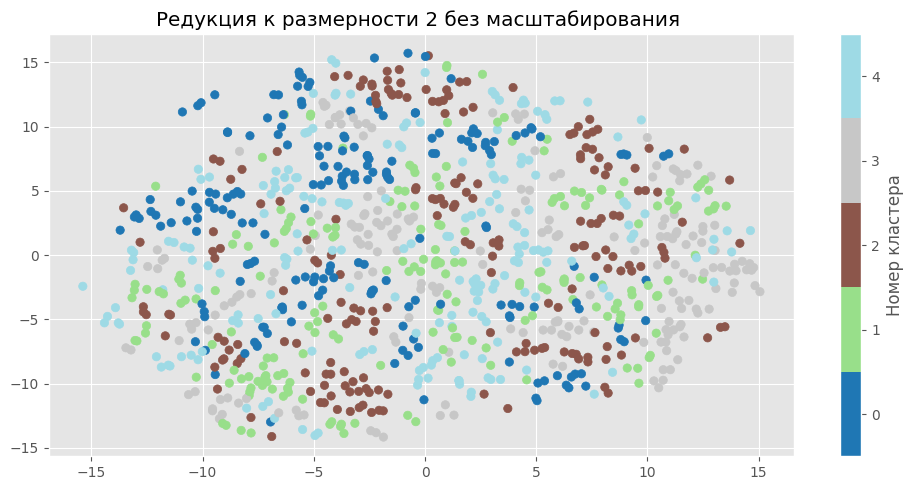

In [218]:
X_embedded = TSNE(n_components=2,
                  perplexity=65, 
                  early_exaggeration=10).fit_transform(data) 
                  
plot_2d_data(X_embedded,
             labels,
             title="Редукция к размерности 2 без масштабирования ");

*Ваш ответ здесь:*

Получилось сохранить кластеры при переходе в низкоразмерное пространство.


#### **Задание 1.b.2 [кросспроверка, 1 балл][код]**
Примените алгоритмы кластеризации из предыдущего пункта к новым данным. Изобразите получившиеся кластеры в векторном пространстве, полученном с помощью `TSNE`. Не забудьте подобрать оптимальные параметры (те же, что и в пункте [**1.a.1**](#task_1.a.1)) для всех алгоритмов. Помните, что большинство алгоритмов кластеризации также являются метрическими и существенно зависят от масштаба признаков.

*Замечание:* Обратите внимание, что применять алгоритмы кластеризации нужно к высокоразмерным векторам, а низкоразмерные вектора необходимо использовать только для визуализации.

In [219]:
def Km(n_clusters):
  labels = KMeans(n_clusters=int(n_clusters)).fit_predict(sd)
  plot_2d_data(X_embedded_scaled, labels, title='KMeans', cmap='tab20')


interactive_plot = interactive(
    Km,
    n_clusters=FloatSlider(value=3, min=1, max=10, step=1, description=r'n_clusters')
)
interactive_plot

interactive(children=(FloatSlider(value=3.0, description='n_clusters', max=10.0, min=1.0, step=1.0), Output())…

In [220]:
def DBSCAN_pr(eps, min_samples):
    labels_DBSCAN = DBSCAN(eps=eps, min_samples=int(min_samples)).fit_predict(sd)
    plot_2d_data(X_embedded_scaled[:500], labels_DBSCAN[:500], title='DBSCAN{}'.format(eps), cmap='tab20')

interactive_plot = interactive(
    DBSCAN_pr,
    eps=FloatSlider(value=4, min=0, max=30, step=0.1, description=r'eps'),
    min_samples=FloatSlider(value=3, min=1, max=10, step=1, description=r'min_samples')
)
interactive_plot

interactive(children=(FloatSlider(value=4.0, description='eps', max=30.0), FloatSlider(value=3.0, description=…

In [221]:
def AggClust(n_clusters):
  labels_AggClust = AgglomerativeClustering(n_clusters=int(n_clusters), linkage= "ward").fit_predict(sd)
  plot_2d_data(X_embedded_scaled, labels_AggClust, title='AgglomerativeClustering', cmap='tab20')


interactive_plot = interactive(
    AggClust,
    n_clusters=FloatSlider(value=3, min=1, max=50, step=1, description=r'n_clusters')
)
interactive_plot

interactive(children=(FloatSlider(value=3.0, description='n_clusters', max=50.0, min=1.0, step=1.0), Output())…

#### **Задание 1.b.3 [кросспроверка, 2 балла][вопрос]**
Опишите получившиеся результаты. Все ли алгоритмы одинаково хорошо разделяют данные? Если какой-то алгоритм не справился с задачей, то предположите почему.

*Ваш ответ здесь:* 

Хуже всего справился DBSCAN, так как кластеры выпуклые и находятся рядом.

## c. Методы оценки кластеризации. Внутренние и внешние метрики.

#### **Задание 1.c.2 [кросспроверка, 1 балл][код, вопрос]**
Посчитайте аналитически коэффициенты силуэта для объектов из примера ниже. Посчитайте силуэт аналитически и сравните его с выводом Вашей функции `silhouette_score`.

*Замечание:* Приведите подробные математические выкладки (очень желательно с использованием $\LaTeX$) (включая значения $s_{i}, d_{i}$). Используйте те же обозначения, что и в теоретической справке выше. Итоговый ответ для силуэта запишите с точностью 3 (три) знака после запятой.

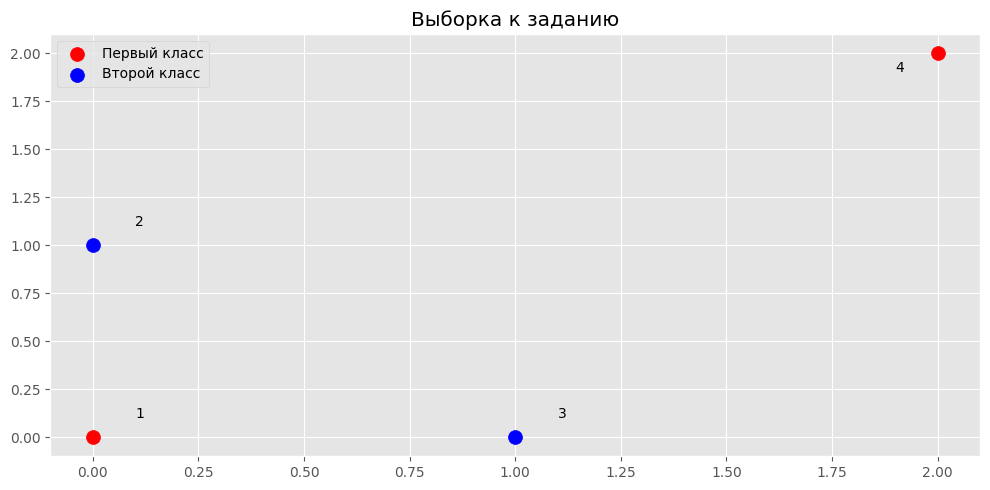

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter([0, 2], [0, 2], s=100, c='r', label='Первый класс')
ax.scatter([0, 1], [1, 0], s=100, c='b', label='Второй класс')

ax.annotate('1', (0.1, 0.1))
ax.annotate('2', (0.1, 1.1))
ax.annotate('3', (1.1, 0.1))
ax.annotate('4', (1.9, 1.9))

ax.set_title('Выборка к заданию')
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

По теореме Пифагора считаем расстояния:

$s_1 = 0,\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  d_1 = \frac{1}{2}(\sqrt{1} + \sqrt{5}),\ \ \ \ \ \ \ \  sil_1 \approx 1$

$s_2 = 0,\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ d_2 = \frac{1}{2}(\sqrt{1} + \sqrt{5}), \ \ \ \ \ \ \  \  sil_2 \approx 1$

$s_3 = \sqrt{1 + 1}, \ \ \ \ \ \ \ d_3 = \frac{1}{2}(\sqrt{1} + \sqrt{1}), \ \ \ \ \ \ \ \ \ \ \  \ \ sil_3 \approx -0.29$

$s_4 = \sqrt{1 + 1},\ \ \ \ \ \ \  d_4 = \frac{1}{2}(\sqrt{5} + \sqrt{5}), \ \ \ \ \ \ \ \  sil_4 \approx 0.367$

$S = \frac{sil_1 + sil_2 + sil_3 + sil_4}{4} \approx 0.51$





In [224]:
data, labels, answer = np.array([[0, 2], [0, 2], [0, 1], [1, 0]]), np.array([0, 0, 1, 1]), 0
silhouette_score(data, labels)

0.5186628122882179

*Ваш ответ здесь:*

Ответ совпал? ОТВЕТ СОВПАЛ!!! (from Incredibles 2)

#### **Задание 1.с.4 [кросспроверка, 2 балла][код, вопрос]** 
<a id='task_1.c.4'></a>
* Для каждого из трёх алгоритмов кластеризации (`KMeans`, `DBSCAN`, `AgglomerativeClustering`) переберите основные параметры (`n_clusters`, `eps`, `min_samples`) и замерьте качество кластеризации многомерных данных с помощью коэффициента силуэта и метрики B-Cubed.
* Для каждого из алгоритмов на одной фигуре изобразите четыре графика — в первой строке два графика с зависимостью коэффициента силуэта и метрики B-Cubed от варьируемого параметра. Во второй строке — визуализация кластеризации с оптимальным параметром, выбранным с помощью первой и второй метрики (можете использовать `plot_2d_data` с параметром `ax`). Для DBSCAN перебирайте оба параметра одновременно и изобразите 2d-heatmap для каждой из метрик. Можете использовать [вспомогательные функции для создания heatmap](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html).
* Совпали ли оптимальные параметры, определённые по этим метрикам? Совпали ли они с теми параметрами которые вы подобрали в предыдущем задании? Предположите почему они совпали/не совпали.
* Можно ли использовать данные метрики для оценки кластеризации между разными алгоритмами? Какая из них лучше отражает качество?

In [228]:
data, labels = make_classification(
    n_samples=1000, n_features=200, n_informative=100,
    n_repeated=0, n_classes=5, n_clusters_per_class=2, weights=None, 
    flip_y=0.01, class_sep=2.5, hypercube=True, shift=0.0, scale=1.0, 
    shuffle=True, random_state=6417
)

In [229]:
n_clusters = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30]
eps = [3, 3.4, 3.8, 4.2, 4.6, 5]
min_samples = [1, 5, 10, 15, 20, 40]

data = StandardScaler().fit_transform(data)

X = TSNE(n_components=2,
         perplexity=65, 
         early_exaggeration=10).fit_transform(data) 

In [230]:
def KMeans_silhouette_bcubed(data, X, labels):
  data = StandardScaler().fit_transform(data)
  bcubed_metric, silhouette_metric = [], []
  n_clusters = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30]

  for n_cl in n_clusters:
    lab = KMeans(n_clusters=n_cl).fit_predict(data)
    silhouette_metric.append(silhouette_score(data, lab))
    bcubed_metric.append(bcubed_score(labels, lab))


  best_lab_KMeans_s = KMeans(n_clusters=n_clusters[np.argmax(silhouette_metric)]).fit_predict(data)
  best_lab_KMeans_b = KMeans(n_clusters=n_clusters[np.argmax(bcubed_metric)]).fit_predict(data)

  fig, ax = plt.subplots(2, 2, figsize=(10, 5))
  fig.tight_layout()
  ax[0, 0].plot(n_clusters, silhouette_metric)
  ax[0, 0].set_xlabel("Number of clusters")
  ax[0, 0].set_title("Silhouette metric")
  ax[0, 1].set_title("Bcubed metric")
  ax[0, 1].set_xlabel("Number of clusters")
  ax[0, 1].plot(n_clusters, bcubed_metric)
  plot_2d_data(X, best_lab_KMeans_s, ax=ax[1, 0], title=" ", scale=5) 
  plot_2d_data(X, best_lab_KMeans_b, ax=ax[1, 1], title=" ", scale=5) 

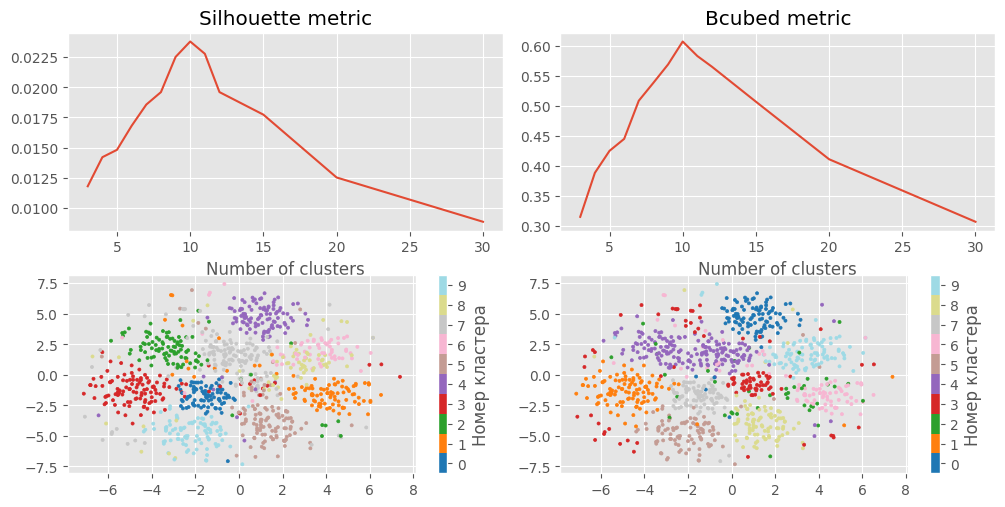

In [231]:
KMeans_silhouette_bcubed(data, X, labels)

In [232]:
def DBSCAN_silhouette_bcubed(data, X, labels):

  bcubed_metric, silhouette_metric = np.zeros((6, 6)), np.zeros((6, 6)), 
  eps = [3, 3.4, 3.8, 4.2, 4.6, 5]
  min_samples = [1, 5, 10, 15, 20, 40]

  for i in range(len(min_samples)):
    for j in range(len(eps)):
      lab = DBSCAN(eps=eps[j], min_samples=min_samples[i]).fit_predict(data)
      silhouette_metric[i, j] = silhouette_score(data, lab)
      bcubed_metric[i, j] = bcubed_score(labels, lab)

  s_max =  np.unravel_index(np.argmax(silhouette_metric, axis=None), silhouette_metric.shape)
  b_max =  np.unravel_index(np.argmax(bcubed_metric, axis=None), bcubed_metric.shape)


  best_lab_DBSCAN_s = DBSCAN(eps=eps[s_max[1]], min_samples=min_samples[s_max[0]]).fit_predict(data)
  best_lab_DBSCAN_b = DBSCAN(eps=eps[b_max[1]], min_samples=min_samples[b_max[0]]).fit_predict(data)

  fig, ax = plt.subplots(2, 2, figsize=(10, 5))
  fig.tight_layout()
  ax[0, 0].plot(eps, silhouette_metric)
  ax[0, 0].set_xlabel("eps")
  ax[0, 0].set_ylabel("Silhouette metric")
  ax[0, 1].plot(eps, bcubed_metric)
  ax[0, 1].set_ylabel("Bcubed metric")
  ax[0, 1].set_xlabel("eps")
  ax[1, 0].imshow( silhouette_metric , cmap = 'autumn' )
  ax[1, 0].set_xlabel("min_samples")
  ax[1, 0].set_ylabel("eps")
  ax[1, 1].imshow( bcubed_metric , cmap = 'autumn' )
  ax[1, 1].set_xlabel("min_samples")
  ax[1, 1].set_ylabel("eps");

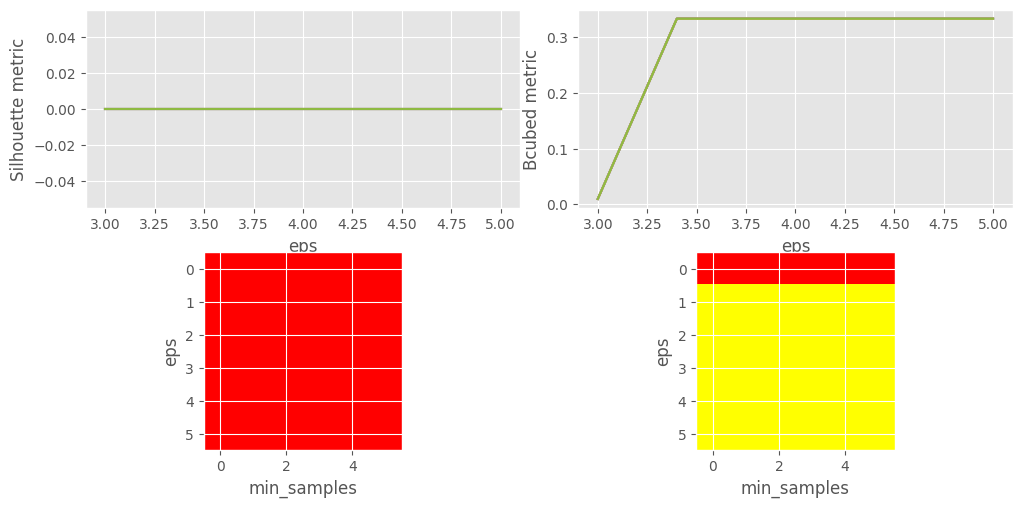

In [234]:
DBSCAN_silhouette_bcubed(data, X, labels)

In [ ]:
def AgglomerativeClustering_silhouette_bcubed(data, X, labels):
  bcubed_metric, silhouette_metric = [], []
  n_clusters = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30]
  data = StandardScaler().fit_transform(data)

  for n_cl in n_clusters:
    lab = AgglomerativeClustering(n_clusters=n_cl).fit_predict(data)
    silhouette_metric.append(silhouette_score(data, lab))
    bcubed_metric.append(bcubed_score(labels, lab))


  best_lab_agg_s = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(silhouette_metric)]).fit_predict(data)
  best_lab_agg_b = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(bcubed_metric)]).fit_predict(data)

  fig, ax = plt.subplots(2, 2, figsize=(10, 5))
  fig.tight_layout()
  ax[0, 0].plot(n_clusters, silhouette_metric)
  ax[0, 1].plot(n_clusters, bcubed_metric)
  ax[0, 0].set_ylabel("Silhouette metric")
  ax[0, 1].set_ylabel("Bcubed metric")
  plot_2d_data(X, best_lab_agg_s, ax=ax[1, 0], title="", scale=5) 
  plot_2d_data(X, best_lab_agg_b, ax=ax[1, 1], title="", scale=5) 
  ax[0, 0].set_xlabel("Number of clusters")
  ax[0, 1].set_xlabel("Number of clusters");

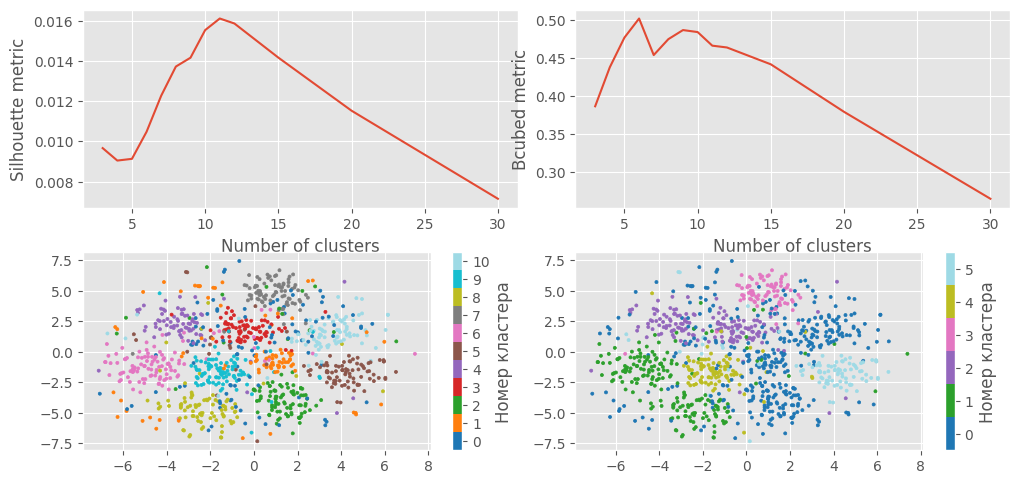

In [235]:
AgglomerativeClustering_silhouette_bcubed(data, X, labels)

*Ваш ответ здесь:* 

* для KMeans метрики совпали. Для AgglomerativeClustering и DBSCAN не совпали.

* использовать данные метрики для оценки кластеризации между разными алгоритмами нельзя, так как у них разные приоритеты для межкластерного и внутрикластерного расстояния

* силуэт лучше отражает качество

# 2. Кластеризация "естественных" данных.   [кросспроверка 13 баллов]

Синтетические данные имеют достаточно простую структуру, поэтому методы снижения размерности позволяют получать хорошее низкоразмерное представление с достаточно выраженными кластерами. Однако, реальные данные могут быть устроены существенно сложнее. Посмотрим как поведут себя методы снижения размерности на датасете с картинками CIFAR10.

Загрузим датасет. Будем использовать только часть обучающей выборки, чтобы ускорить вычисления на высокоразмерных данных.

In [236]:
cifar10_test_dataset = CIFAR10('./cifar10', train=False, download=True)
cifar10_train_dataset = CIFAR10('./cifar10', train=True, download=False)

cifar10_labels_test = np.array(cifar10_test_dataset.targets)
cifar10_labels_train = np.array(cifar10_train_dataset.targets)

cifar10_images_test = cifar10_test_dataset.data
cifar10_images_train = cifar10_train_dataset.data

cifar10_images_train, _, cifar10_labels_train, _ = train_test_split(
    cifar10_images_train, cifar10_labels_train, 
    train_size=cifar10_images_test.shape[0], stratify=cifar10_labels_train, random_state=6886
)

cifar10_data_test = (cifar10_images_test.astype(np.float32) / 255.0).reshape([cifar10_images_test.shape[0], -1])
cifar10_data_train = (cifar10_images_train.astype(np.float32) / 255.0).reshape([cifar10_images_train.shape[0], -1])

Files already downloaded and verified


Отобразим данные в проекции на две случайные оси. Для удобства воспользуемся здесь ещё одним вариантом динамического контента в jupyter notebook — при наведении на точку на графике будем отображать исходную картинку.

In [237]:
def plot_interactive(lowd_data, images, labels, names, n_dots=1000, image_scale=1.0,
                     title='Распределение данных CIFAR10 в проекции на 2 случайные оси'):
    with matplotlib.rc_context(rc={
        'font.size': image_scale * matplotlib.rcParams['font.size'],
        'xtick.major.size': image_scale * matplotlib.rcParams['xtick.major.size'],
        'xtick.minor.size': image_scale * matplotlib.rcParams['xtick.minor.size'],
        'ytick.major.size': image_scale * matplotlib.rcParams['ytick.major.size'],
        'ytick.minor.size': image_scale * matplotlib.rcParams['ytick.minor.size'],
        
        'axes.linewidth': image_scale * matplotlib.rcParams['axes.linewidth'],
        'grid.linewidth': image_scale * matplotlib.rcParams['grid.linewidth'],
        'patch.linewidth': image_scale * matplotlib.rcParams['patch.linewidth'],
        'xtick.major.width': image_scale * matplotlib.rcParams['xtick.major.width'],
        'xtick.minor.width': image_scale * matplotlib.rcParams['xtick.minor.width'],
        'ytick.major.width': image_scale * matplotlib.rcParams['ytick.major.width'],
        'ytick.minor.width': image_scale * matplotlib.rcParams['ytick.minor.width'],
        
        'lines.markeredgewidth': image_scale * matplotlib.rcParams['lines.markeredgewidth'],
    }):
        fig, ax = plt.subplots(1, 1, figsize=(image_scale * 10, image_scale * 5))
        fig.set_dpi(300)
        ax.grid(True)

        n_clusters = len(np.unique(labels))

        scatter = plt.scatter(
            lowd_data[:n_dots, 0], lowd_data[:n_dots, 1], s=image_scale * 5, 
            c=labels[:n_dots], cmap=plt.get_cmap('tab20', n_clusters), edgecolors='none'
        )

        cbar = plt.colorbar(scatter, ax=ax, label='Название кластера')
        cbar.set_ticks(np.min(labels[:n_dots]) + (np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters)
        cbar.set_ticklabels(names)

        offset_image = OffsetImage(images[0], zoom=image_scale * 2.0)
        ann_bbox = AnnotationBbox(
            offset_image, (0,0), xybox=(image_scale * 50., image_scale * 50.), xycoords='data',
            boxcoords="offset points", pad=0.3, arrowprops=dict(
                arrowstyle='->, head_length={0:.2f}, head_width={1:.2f}'.format(
                    image_scale * 0.4, image_scale * 0.2
                )
            )
        )
        ax.add_artist(ann_bbox)
        ax.set_title(title)
        ann_bbox.set_visible(False)

        def image_hover(event):
            if scatter.contains(event)[0]:
                ind, *_ = scatter.contains(event)[1]["ind"]
                w, h = fig.get_size_inches() * fig.dpi
                ws = (event.x > w / 2.) * -1 + (event.x <= w / 2.) 
                hs = (event.y > h / 2.) * -1 + (event.y <= h / 2.)
                ann_bbox.xybox = (image_scale * 50.0 * ws, image_scale * 50.0 * hs)
                ann_bbox.set_visible(True)
                ann_bbox.xy =(lowd_data[ind, 0], lowd_data[ind, 1])
                offset_image.set_data(images[ind])
            else:
                ann_bbox.set_visible(False)
            fig.canvas.draw_idle()

        fig.canvas.mpl_connect('motion_notify_event', image_hover) 

        plt.show()

In [238]:
%matplotlib ipympl
matplotlib.rcParams['figure.dpi'] = 300

# Для работы в Google Colab нужно выполнить специфичную магию
# Обычно, она не срабатывает с первого раза, поэтому может потребоваться
#   несколько раз выполнить ячейку и несколько раз попробовать нарисовать график
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

In [239]:
set_base_settings()

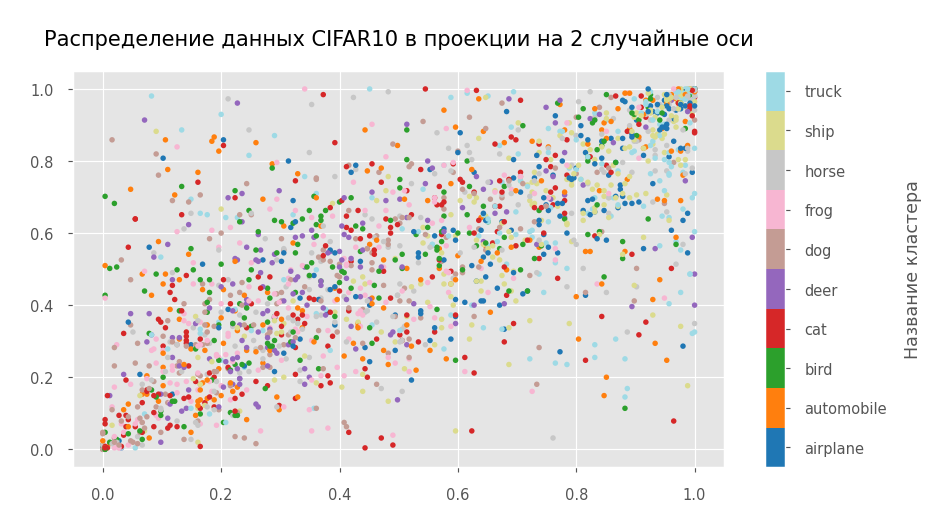

In [240]:
# Если картинка окажется слишком маленькой/большой, то поменяйте image_scale на подходящее значение
plot_interactive(
    cifar10_data_train[:, [17, 64]], cifar10_images_train, cifar10_labels_train, 
    cifar10_test_dataset.classes, n_dots=2000, image_scale=0.35
)

Вернёмся в статичный режим отрисовки изображений:

In [241]:
set_base_settings()

#### **Задание 2.1 [кросспроверка, 1 балл][код]**
<a id='task_2.1'></a>
Воспользуйтесь алгоритмами снижения размерности `TSNE`, `UMAP`, `Isomap`, `KernelPCA` для визуализации картинок.

Полезные ссылки:
* [TSNE](https://distill.pub/2016/misread-tsne/)
* [UMAP](https://pair-code.github.io/understanding-umap/)
* [Isomap](https://www.sjsu.edu/faculty/guangliang.chen/Math253S20/lec10ISOmap.pdf)
* [Kernel](https://web.stanford.edu/~lmackey/stats306b/doc/stats306b-spring14-lecture8_slides.pdf) [PCA](https://web.stanford.edu/~lmackey/stats306b/doc/stats306b-spring14-lecture8_scribed.pdf)

Ссылки на документацию:
* [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
* [UMAP](https://umap-learn.readthedocs.io/en/latest/)
* [Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html)
* [KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html)

Постройте визуализацию низкоразмерного представления, полученного с помощью этих моделей — изобразите четыре графика в одной строке. Во второй строке отобразите результат применения обученных моделей на тестовой выборке. Если для данного алгоритма невозможно сделать предсказания на тестовой выборке — оставьте соответствующий график пустым. Обозначьте разными цветами разные классы объектов. Для повышения производительности можете отобразить только часть выборки на графике ($1000\text{-}2000$ объектов).

*Замечание:* обратите внимание, что все алгоритмы снижения размерности также требуют правильного <font color="red">масштабирования признаков</font>, для корректной работы и интерпретируемых результатов.

In [242]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [243]:
def test(X_train, lab_train, X_test, lab_test):
  X_train_net = X_train[:1000]
  X_test_net = X_test[:1000]

  X_test_net = StandardScaler().fit_transform(X_test_net)
  X_train_net = StandardScaler().fit_transform(X_train_net)


  UMAP_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.0) 
  UMAP_model.fit(X_train_net) 
  X_UMAP_test = UMAP_model.transform(X_test_net) 
  X_UMAP_train = UMAP_model.transform(X_train_net) 

  TSNE_model = TSNE(n_components=2,
                    perplexity=35.0, 
                    early_exaggeration=14.0)
  X_TSNE = TSNE_model.fit_transform(X_train_net) 

  KernelPCA_model = KernelPCA(n_components=2)
  KernelPCA_model.fit(X_train_net) 
  X_KernelPCA_test = KernelPCA_model.transform(X_test_net) 
  X_KernelPCA_train = KernelPCA_model.transform(X_train_net) 

  Isomap_model = Isomap(n_neighbors=15)
  Isomap_model.fit(X_train_net) 
  X_Isomap_test = Isomap_model.transform(X_test_net) 
  X_Isomap_train = Isomap_model.transform(X_train_net) 

  fig, ax = plt.subplots(2, 4, figsize=(10, 5))
  fig.tight_layout()
  plot_2d_data(X_TSNE, lab_train, ax =ax[0, 0], title="TSNE", scale=3)

  plot_2d_data(X_UMAP_test, lab_test, ax =ax[0, 1], title="UMAP", scale=3)
  plot_2d_data(X_UMAP_train, lab_train, ax =ax[1, 1], title="UMAP", scale=3)

  plot_2d_data(X_KernelPCA_test, lab_test, ax =ax[0, 2], title="KernelPCA", scale=3)
  plot_2d_data(X_KernelPCA_train, lab_train, ax =ax[1, 2], title="KernelPCA", scale=3)

  plot_2d_data(X_Isomap_test, lab_test, ax =ax[0, 3], title="Isomap", scale=3)
  plot_2d_data(X_Isomap_train, lab_train, ax =ax[1, 3], title="Isomap", scale=3)

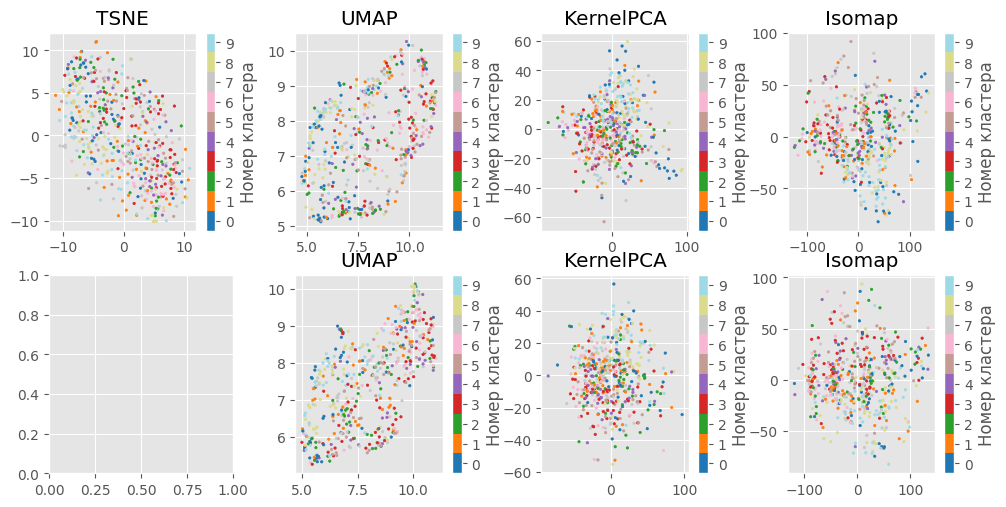

In [244]:
test(cifar10_data_train[:500],cifar10_labels_train[:500],  cifar10_data_test[:500], cifar10_labels_test[:500]);

#### **Задание 2.2 [кросспроверка, 1 балл][вопрос]**
Опишите увиденное. Почему алгоритмы могли отработать не так, как вы ожидали? Аргументируйте свой ответ.

*Ваш ответ здесь:* 

данных оказалось недостаточно для обучения модели




#### **Задание 2.3 [кросспроверка, 2 балла][вопрос]**
Методы снижения размерности, как и другие метрические методы испытывают трудности при работе с данными высокой размерности. Напишите <font color="red">как минимум 2 (две) причины</font>, почему.

*Ваш ответ здесь:* 

* исходное пространство высокой размерности редуцируется с потерей данных (но с надеждой, что остаётся наиболее важная информация)  

* при снижении размерности может появиться шум, который алгоритм потом воспримет как значимый признак

Один из способов решения этих проблем — перейти в другое, более репрезентативное пространство признаков, где объекты будут расположены в многообразии, которое легче представить в двумерном пространстве. Чтобы выполнить такое преобразование воспользуемся типичным подходом **Transfer Learning** — предобученными нейронными сетями (обзор этой области можно посмотреть в [данной статье](https://arxiv.org/pdf/1911.02685.pdf)). С помощью глубокой сети обученной на другом наборе изображений (`ImageNet`) мы перейдём в новое векторное пространство и затем применим методы снижения размерности.

Так как локальный подсчёт эмбеддингов изображений может занять много времени, Вы можете скачать их [по прямой ссылке](https://drive.google.com/file/d/16UgWo1Emt9ar1O4h2Xxed0ZpJZ0OG5V-/view?usp=share_link) или через `gdown`:

In [245]:
gdown.download(id='16UgWo1Emt9ar1O4h2Xxed0ZpJZ0OG5V-', output='cifar10_deep_features.npy')

Downloading...
From: https://drive.google.com/uc?id=16UgWo1Emt9ar1O4h2Xxed0ZpJZ0OG5V-
To: /content/cifar10_deep_features.npy
100%|██████████| 164M/164M [00:01<00:00, 131MB/s]


'cifar10_deep_features.npy'

In [246]:
FEATURES_PATH = './cifar10_deep_features.npy'

if not os.path.exists(FEATURES_PATH):
    deep_cnn = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))

    cifar10_tensors_test = torch.nn.functional.interpolate(torch.tensor(
        cifar10_images_test.transpose(0, 3, 1, 2)
    ), size=139).numpy().transpose(0, 2, 3, 1).astype(np.float32)
    cifar10_tensors_train = torch.nn.functional.interpolate(torch.tensor(
        cifar10_images_train.transpose(0, 3, 1, 2)
    ), size=139).numpy().transpose(0, 2, 3, 1).astype(np.float32)

    cifar10_deep_features_test = deep_cnn.predict(
        preprocess_input(cifar10_tensors_test)
    ).mean(axis=(1, 2)).reshape([cifar10_tensors_test.shape[0], -1])
    cifar10_deep_features_train = deep_cnn.predict(
        preprocess_input(cifar10_tensors_train)
    ).mean(axis=(1, 2)).reshape([cifar10_tensors_train.shape[0], -1])

    np.save(FEATURES_PATH, [cifar10_deep_features_test, cifar10_deep_features_train])
else:
    cifar10_deep_features_test, cifar10_deep_features_train = np.load(FEATURES_PATH, allow_pickle=True)

#### **Задание 2.4 [кросспроверка, 2 балла][код]**
Используйте выделенные признаки для обучения алгоритмов из предыдущего пункта. Постройте графики. Замечание из пункта [**2.1**](#task_2.1) остаётся в силе.

In [247]:
X_train_net = StandardScaler().fit_transform(cifar10_deep_features_train[:1000])
X_test_net = StandardScaler().fit_transform(cifar10_deep_features_test[:1000])

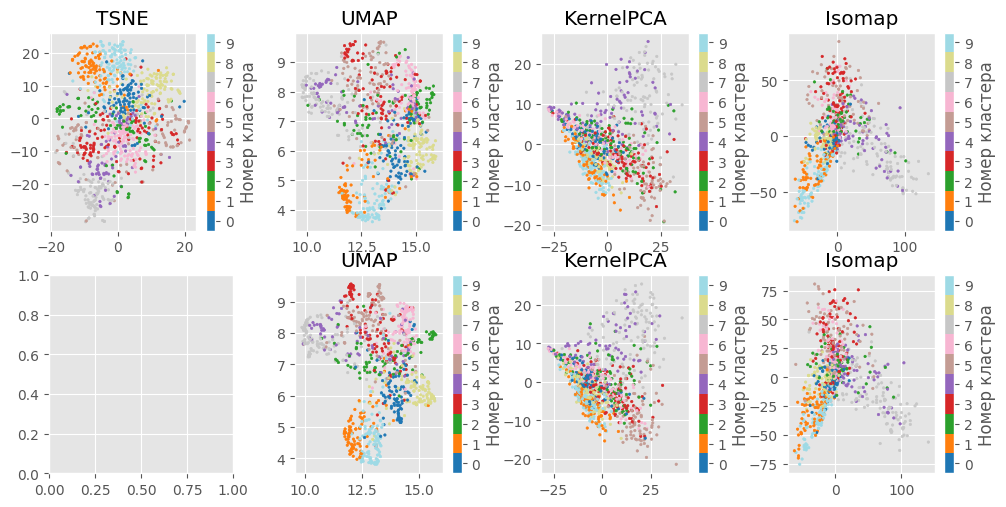

In [248]:
test(X_train_net ,cifar10_labels_train[:1000], X_test_net, cifar10_labels_test[:1000]);

#### **Задание 2.5 [кросспроверка, 2 балла][вопрос]** 
1. Есть ли какие-то изменения по сравнению с использованием исходных признаков? 
2. Как вы думаете, почему использование глубоких признаков помогло/не помогло в задаче снижения размерности?
3. Какой алгоритм показал себя лучше на ваш взгляд? 
4. Согласованы ли преобразования на обучающей и тестовых выборках? Какие недостатки есть в том, что преобразование на тестовой выборке выглядит отлично от низкоразмерного представления обучающей выборки?
5. Какие из алгоритмов можно использовать в качестве первого шага по снижению размерности в задачах машинного обучения? Какой из них использовали бы вы?

*Ваш ответ здесь:* 

1. есть положительные изменения на алгоритме UMAP
2. помогло, модель смогла лучше обучиться 
3. UMAP
4. согласованы для UMAP и isomap
5. UMAP и Isomap 

Далее, для визуализации кластеризации используйте один из методов снижения размерности на ваш выбор и то векторное представление, которое лучше всего себя проявило (исходное или полученное с помощью глубокой сети). Кластеризацию обучайте также на наиболее подходящем высокоразмерном векторном представлении.

#### **Задание 2.6 [кросспроверка, 1 балл][код, вопрос]**
Изобразите выборку CIFAR10 с помощью выбранного алгоритма снижения размерности.

*Совет*: Изобразите результат с помощью `plot_interactive`, чтобы изучить особенности кластеризации в соответствии с исходными изображениями. Если вы нашли интересные особенности — напишите про это.

In [249]:
%matplotlib ipympl
matplotlib.rcParams['figure.dpi'] = 300

# Для работы в Google Colab нужно выполнить специфичную магию
# Обычно, она не срабатывает с первого раза, поэтому может потребоваться
#   несколько раз выполнить ячейку и несколько раз попробовать нарисовать график
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

In [250]:
set_base_settings()

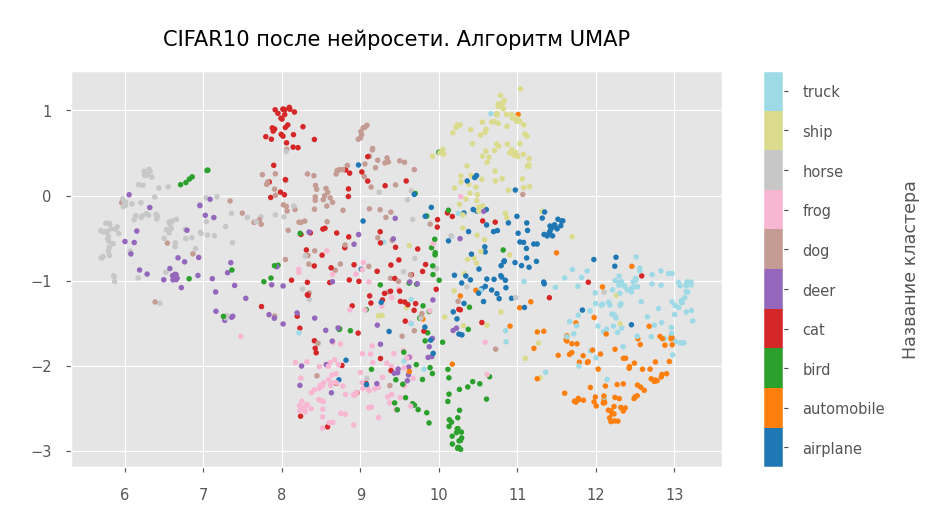

In [251]:
UMAP_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.0) 
X_UMAP_train = UMAP_model.fit_transform(X_train_net[:1000]) 



plot_interactive(
    X_UMAP_train[:1000], cifar10_images_train, cifar10_labels_train[:1000], 
    cifar10_test_dataset.classes, n_dots=2000,
    image_scale=0.35, title="CIFAR10 после нейросети. Алгоритм UMAP"
)

Вернёмся в статичный режим отрисовки изображений:

In [252]:
set_base_settings()

Теперь, когда мы можем визуализировать кластеризацию, можно сравнить алгоритмы из первой части на естественных данных.

#### **Задание 2.7 [кросспроверка, 2 балла][код]**
Подберите параметры `KMeans`, `DBSCAN`, `AgglomerativeClustering` используя силуэт и B-Cubed. Визуализируйте получившиеся кластеризации также, как и в задании [**1.с.4**](#task_1.c.4). Для ускорения перебора можете производить его на небольшой доле от всех объектов ($1000\text{-}2000$ объектов).

*Замечание:* Алгоритмы кластеризации нужно применять к <font color="red">исходному векторному представлению</font>. Снижение размерности используется только для визуализации. 

In [253]:
n_objects = 2000

In [254]:
UMAP_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.0) 
UMAP_model.fit(X_train_net) 
X_UMAP_train = UMAP_model.transform(X_train_net) 

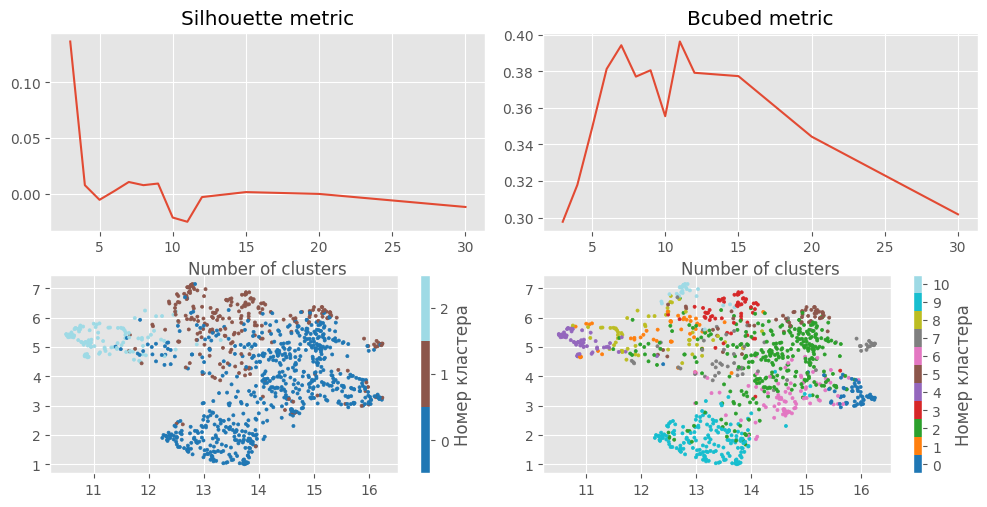

In [255]:
KMeans_silhouette_bcubed(X_train_net, X_UMAP_train, cifar10_labels_train[:1000])

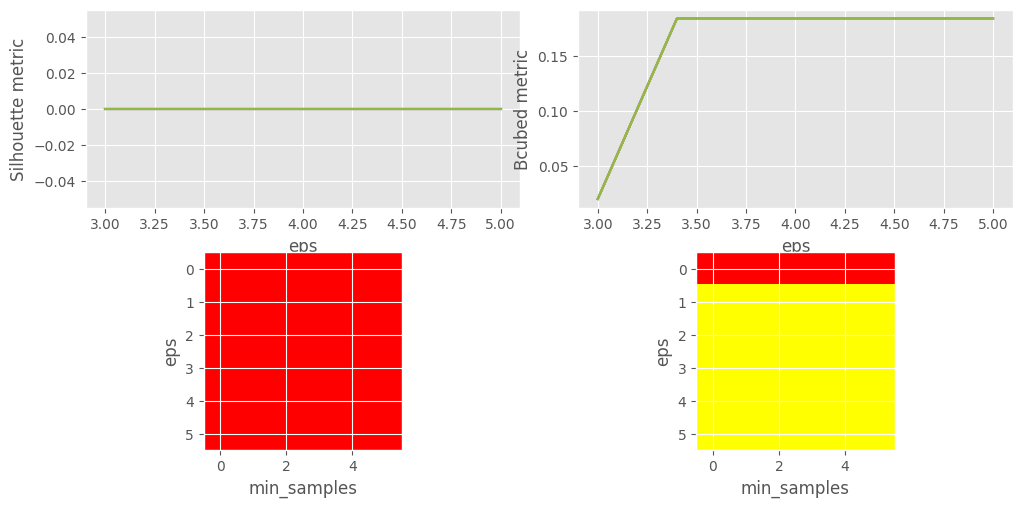

In [256]:
DBSCAN_silhouette_bcubed(X_train_net, X_UMAP_train, cifar10_labels_train[:1000])

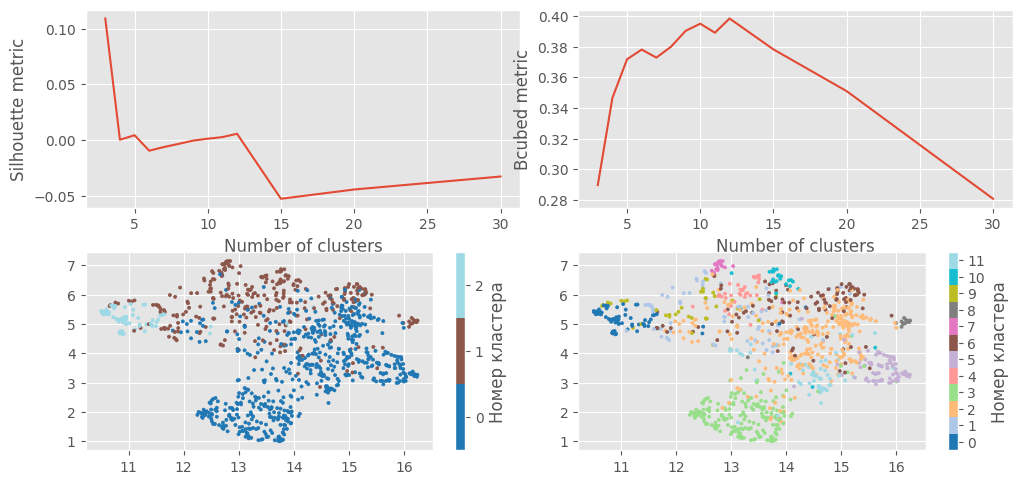

In [257]:
AgglomerativeClustering_silhouette_bcubed(X_train_net, X_UMAP_train, cifar10_labels_train[:1000])

#### **Задание 2.8 [кросспроверка, 2 балла][вопрос]** 
1. Какие алгоритмы справились с кластеризацией естественных данных? 
2. Получилось ли подобрать оптимальное число кластеров с помощью BCubed и коэффициента силуэта?
3. Объясните почему коэффициент силуэта не позволил выполнить подбор оптимальных гиперпараметров.

*Ваш ответ здесь:* 

* KMeans
* BCubed 

#### **Задание 2.9 [вопрос]**

Интересный способ визуализации Иерархической кластеризации — построение дендрограммы. Такой способ визуализации позволяет анализировать, как именно связаны между собой объекты, подбирать оптимальное число кластеров, а также определять, какие классы отделяются "хорошо" от других классов, а какие классы перемешаны в одном кластере.

In [258]:
def plot_dendrogram(model, labels, classes, ax):
    n_classes = len(classes)
    n_samples = len(model.labels_)
    n_u_connections = model.children_.shape[0]
    colors = plt.get_cmap('tab20', n_classes).colors
    
    bin_counts = np.zeros([n_u_connections, n_classes])
    for i, merge in enumerate(model.children_):
        current_bin_count = np.zeros(n_classes)
        for child_idx in merge:
            if child_idx < n_samples:
                current_bin_count[labels[child_idx]] += 1
            else:
                current_bin_count += bin_counts[child_idx - n_samples]
                
        bin_counts[i] = current_bin_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, np.sum(bin_counts, axis=1)]
    ).astype(float)

    def leaf_label_func(idx):
        if idx < len(labels):
            return None
        else:
            ratio = 100 * np.max(bin_counts[idx - n_samples]) / np.sum(bin_counts[idx - n_samples])
            if ratio < 100:
                return '{0:.0f}%'.format(ratio)
            else:
                return None
    
    def link_color_func(idx):
        mode_class = np.argmax(bin_counts[idx - n_samples])
        return matplotlib.colors.to_hex(colors[mode_class], keep_alpha=True)
    
    scipy.cluster.hierarchy.dendrogram(
        linkage_matrix, ax=ax, link_color_func=link_color_func, leaf_label_func=leaf_label_func, 
        orientation='right', truncate_mode="level", p=9
    )
    
    for idx, class_name in enumerate(classes):
        ax.plot([], [], c=matplotlib.colors.to_hex(colors[idx], keep_alpha=True), label=class_name)
    ax.legend()
    
    # Удалим накладывающиеся метки 
    threshold = 55
    prev_position = -(threshold + 1)

    y_labels = ax.get_yaxis().get_ticklabels()
    for label in y_labels:
        if label.get_text() == '':
            continue
            
        _, position = label.get_position()
        if position - prev_position < threshold:
            label.set_text('')
        else:
            prev_position = position
    ax.get_yaxis().set_ticklabels(y_labels) 
    
    ax.set_xlabel('Расстояние между кластерами')
    ax.set_ylabel('Доля объектов наибольшего класса в данном кластере')
    
    ax.set_title('Дендрограмма Иерархической Кластеризации')

In [259]:
n_objects = 2000
model = AgglomerativeClustering(
    n_clusters=None, distance_threshold=0.0, compute_distances=True, compute_full_tree=True
)

X_UMAP = UMAP(n_neighbors=15, n_components=2, min_dist=0.0).fit_transform(cifar10_deep_features_train[:n_objects]) 
model = model.fit_predict(X_UMAP)


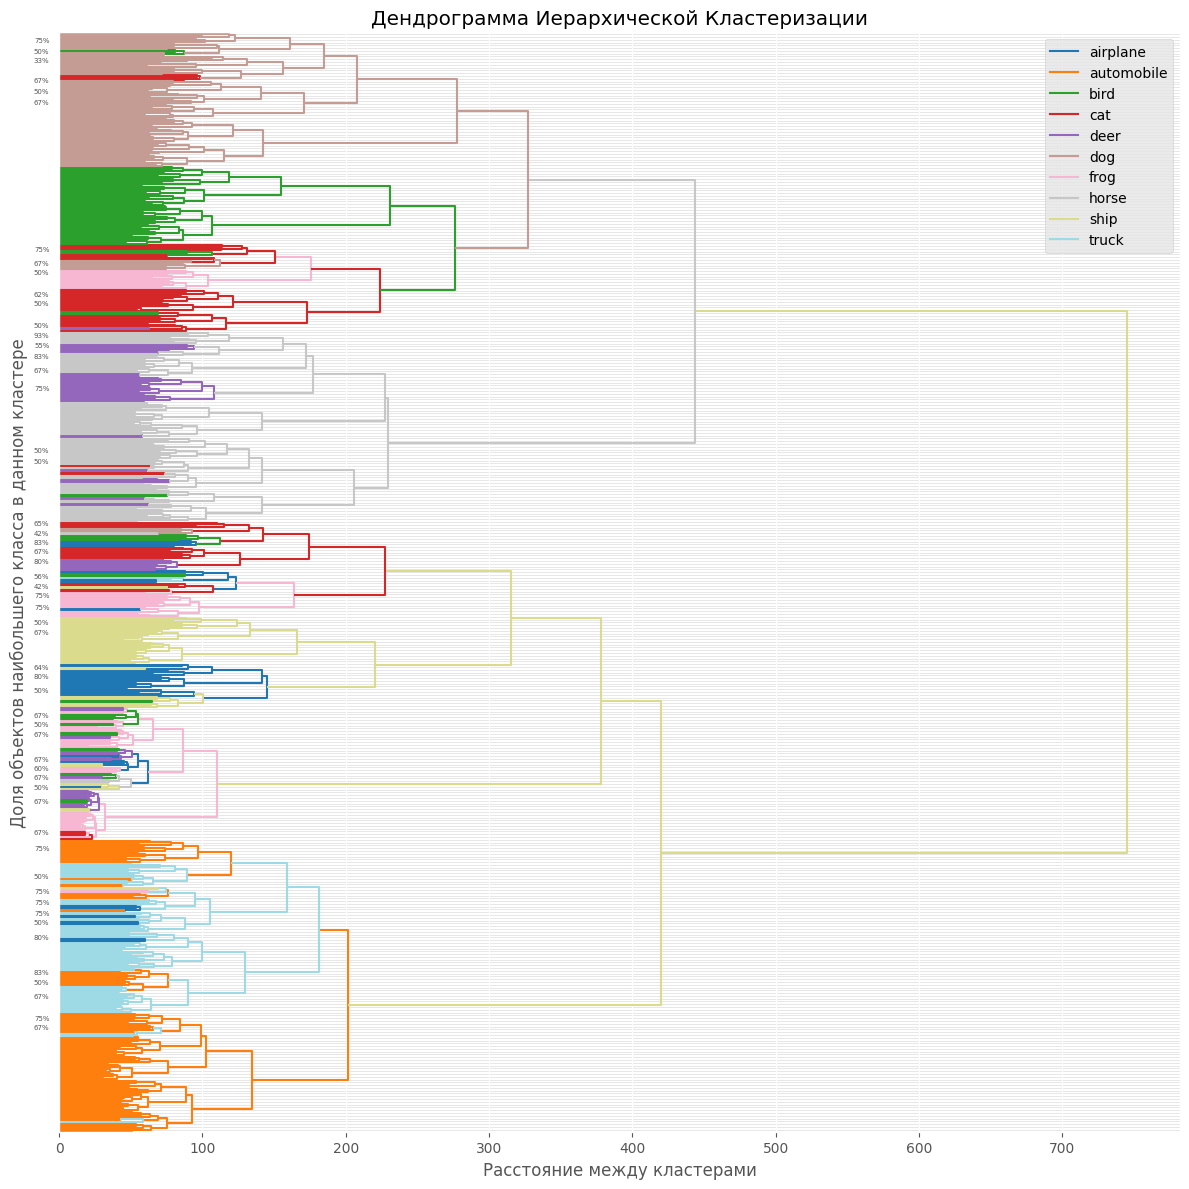

In [260]:
n_objects = 2000
model = AgglomerativeClustering(
    n_clusters=None, distance_threshold=0.0, compute_distances=True, compute_full_tree=True
)
model = model.fit(cifar10_deep_features_train[:n_objects])

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

plot_dendrogram(
    model, 
    labels=cifar10_labels_train[:n_objects], 
    classes=cifar10_train_dataset.classes, 
    ax=ax
)
    
fig.tight_layout()
plt.show()

Проанализируйте получившуюся дендрограмму. Напишите свои наблюдения ниже.

*Ваш ответ здесь:* 

На каждом шаге выбирается класс, у которого больше всего объектов на предыдущем разбиении. Хорошая стратегия, нечего добавить